# ODEs continued
 
In the previous practical about ODEs we investigated a small biochemical network. For the example our goal is to define the system of ODEs and fit it to some data. For this example we will focus on a continuous stirred tank reactor where we are supplying some feed stock to a bioreactor, which consumes the feed supplying its biomass. Our goal is to characterise the growth rate and perform a simulation study about what happens under increasing flow rates.

## Defining the model system

There are three what are referred to as states in this system: the volume (V), the biomass (X), and substrate (S).

![CSTR](img/cstr.svg)

These processes are generally well defined. By listing out each of the processes and their rates we should be able to defined
the system of ordinary differential equations in order to simulate this system. The most simple process is the volume and is 
determined by how much is entering the system vs how fast the water can leave the system. We can be fairly sure about how much
water is entering and leaving the system and can ensure that the volume remains constant. This means that:

$$
F_{out} = F_{in}
$$

This is a simplification as the volume should be height, however, considering we are assume our reactor has a constant cross-section
we can bundle all of the constants into $C$ and treat them as a single parameter (by: $\sqrt{a\times b} = \sqrt{a}\times\sqrt{b}$).
Following this we can assume the same growth kinetics and substrate consumption that we assumed in the previous model:

\begin{align*}
\mu &= \frac{\mu_{max}\cdot S(t)}{K_{S} + S(t)}\cdot \\
q_s &= -\gamma \cdot \frac{\mu_{max}\cdot S(t)}{K_{s} + S(t)}
\end{align*}
$$

where $K_S$ is the monod constant for the substrate concentration, $X(t)$ is the concentration
of $X$ at time $t$, $S(t)$ is the concentration of $S$ at time $t$, $\mu_{max}$ is the maximum
growth rate, and $\gamma$ is the yield of $S$ per amount of $X$ (This assumes it is growth coupled).

One thing to note about this system is that even though the rates are a function of concentrations
the states should be solved as what we call _extrinsic_ values, meaning we should focus on the absolute
amount of those values. This is in opposition to _intrinsic_ values, these can be though of as densities such
as concentration. As a hint, the mass balances sould have this form:

$$
\begin{align*}
\frac{dXV}{dt} &= ... \\
\frac{dSV}{dt} &= ... \\
\end{align*}
$$

And because we do not have to solve for the extrinsic values and solve it for dimensionless properties we can instead write it as:

$$
\begin{align*}
\frac{dX}{dt} &= ... \\
\frac{dS}{dt} &= ... \\
\end{align*}
$$

Where rather than being a function of $F_{in}$ and $V$, we can write it as a function of $D = \frac{F_{in}}{V}$

and the list of parameters is as follows:
- $K_S$
- $\mu_{max}$
- $\gamma$
- $D$
- $S_F$


In [1]:
import os
from functools import partial

os.environ["JAX_NUM_CPU_DEVICES"] = "3"
os.environ["JAX_ENABLE_X64"] = "1"

import operator
import arviz as az
import diffrax
import numpy as np
import jax

from jax import numpy as jnp
from jax import scipy as jsp
from matplotlib import pyplot as plt

### Specify true parameters

This code specifies the dimensions of our problem.

In [2]:
N_reactors= 4
N_timepoint = 50
N_meas = 5
duration = 50
reactors = [i + 1 for i in range(N_reactors)]
species = ["biomass", "substrate"]
measurement_times = jnp.linspace(0.01, duration, N_meas)
timepoints = jnp.linspace(0.01, duration, N_timepoint)

Similar to before we are going to initialise the random number generators

In [3]:
SEED = 12345
key = jax.random.key(seed=SEED)
rng_key, key = jax.random.split(key)

We know that all of the parameters are going to be positively constrained so we should
work with log values and secondly, we are assuming that this is going to be a large bioreactor
and that there will be minimal reactor-to-reactor differences, therefore, we can assume a pooled
model for the strain behaviour

In [4]:
mu_max = 5
S_F = 5
D = jnp.linspace(0.5, 3, N_reactors)
ks = 2
gamma = 0.7
V_0 = 1
X_0 = 0.05
S_0 = 2



true_params = {
    "log_mu_max": jnp.log(mu_max),
    "log_ks": jnp.log(ks),
    "log_S_F": jnp.log(S_F),
    "log_D": jnp.log(D),
    "log_gamma": jnp.log(gamma),
    "log_conc_init": jnp.log(jnp.array([X_0, S_0])),
    "log_sigma": jnp.log(jnp.array([0.05, 0.1])),
}

def get_reactor_params(reactor_ix, params):
    def slice(leaf):
        return (
            leaf[reactor_ix]
            if (hasattr(leaf, "shape") and leaf.ndim > 0 and leaf.shape[0] == N_reactors)
            else leaf
        )

    return jax.tree.map(slice, params)

true_params_reactor_2 = get_reactor_params(3, true_params)
true_params_reactor_2

{'log_D': Array(1.09861229, dtype=float64),
 'log_S_F': Array(1.60943791, dtype=float64, weak_type=True),
 'log_conc_init': Array([-2.99573227,  0.69314718], dtype=float64),
 'log_gamma': Array(-0.35667494, dtype=float64, weak_type=True),
 'log_ks': Array(0.69314718, dtype=float64, weak_type=True),
 'log_mu_max': Array(1.60943791, dtype=float64, weak_type=True),
 'log_sigma': Array([-2.99573227, -2.30258509], dtype=float64)}

### Defining the dynamics
Much like before we will need to define the RHS of our system of differential equations, this is also
referred to as the term in diffrax.

In [5]:
def get_mu(S, mu_max, ks):
    return mu_max * (S)/(ks + S)
    
@jax.jit
def reactor_kinetics(t, y, args):
    X, S = y
    S_F = jnp.exp(args["log_S_F"])
    D = jnp.exp(args["log_D"])
    mu_max = jnp.exp(args["log_mu_max"])
    ks = jnp.exp(args["log_ks"])
    gamma = jnp.exp(args["log_gamma"])
    mu = get_mu(S, mu_max, ks)
    return jnp.array([mu * X - D*X, D*(S_F-S) - gamma * mu * X])

### Solving the initial value problem

The next step is to wrap this function using the diffrax class `ODETerm`

In [6]:
reactor_term = diffrax.ODETerm(reactor_kinetics)

Now we can choose a solver, stepsize controller and initial sensitivity

In [7]:
solver = diffrax.Kvaerno5()
stepsize_controller = diffrax.PIDController(rtol=1e-8, atol=1e-8)
dt0 = 0.001


Now we can make a function for solving our initial value problem

In [8]:
@jax.jit
def solve_reactor(args, timepoints):
    t0 = 0.0
    tf = timepoints[-1]
    y0 = jnp.exp(args["log_conc_init"])
    saveat = diffrax.SaveAt(ts=timepoints)
    return diffrax.diffeqsolve(
        reactor_term,
        solver,
        t0=t0,
        t1=tf,
        dt0=dt0,
        y0=y0,
        saveat=saveat,
        args=args,
        stepsize_controller=stepsize_controller,
        max_steps=int(1e5)
    )

solution = solve_reactor(args=true_params_reactor_2, timepoints=timepoints)

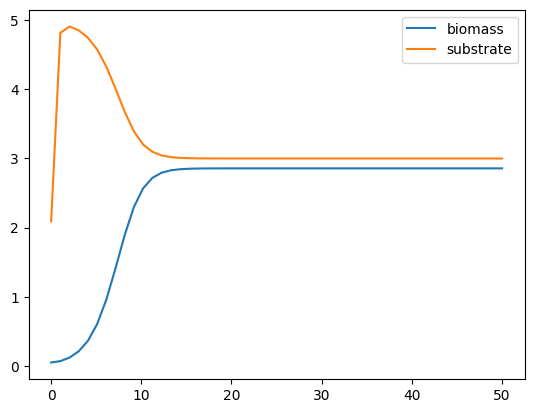

In [9]:
f, ax = plt.subplots()
for yi, label in zip(solution.ys.T, species):
    ax.plot(timepoints, yi, label=label)
ax.legend()

## Defining a model

### Joint log density function

We can use similar log-density functions as before due to the ability to operate over PyTrees

In [10]:
def prior_log_density(params, prior):
    loc, scale = prior
    return jax.tree.map(jsp.stats.norm.logpdf, params, loc, scale)

example_prior_loc = jax.tree.map(jnp.array, true_params)
example_prior_scale = jax.tree.map(
    lambda x: jnp.full_like(x, 0.1),
    true_params,
)
example_prior_scale["log_D"] = jnp.full_like(example_prior_scale["log_D"], 0.01)
example_prior = (example_prior_loc, example_prior_scale)
example_log_prior = prior_log_density(true_params, example_prior)
example_log_prior

{'log_D': Array([3.68623165, 3.68623165, 3.68623165, 3.68623165], dtype=float64),
 'log_S_F': Array(1.38364656, dtype=float64, weak_type=True),
 'log_conc_init': Array([1.38364656, 1.38364656], dtype=float64),
 'log_gamma': Array(1.38364656, dtype=float64, weak_type=True),
 'log_ks': Array(1.38364656, dtype=float64, weak_type=True),
 'log_mu_max': Array(1.38364656, dtype=float64, weak_type=True),
 'log_sigma': Array([1.38364656, 1.38364656], dtype=float64)}

now the likelihood:

In [11]:
def likelihood_log_density(obs, params, measurement_times):
    n_reactor = params["log_D"].shape[0]
    reactors = jnp.arange(n_reactor)
    yhat = jax.vmap(
        lambda i: solve_reactor(get_reactor_params(i, params), measurement_times).ys,
    )(reactors)
    log_yhat = jnp.log(jnp.maximum(yhat, jnp.full_like(yhat, 1e-9)))
    sigma = jnp.exp(params["log_sigma"])
    log_obs = jnp.log(obs)
    return jsp.stats.norm.logpdf(log_obs, log_yhat, sigma)


def simulate_measurements(key, params, measurement_times):
    n_reactor = params["log_D"].shape[0]
    reactors = jnp.arange(n_reactor)
    yhat = jax.vmap(
        lambda i: solve_reactor(get_reactor_params(i, params), measurement_times).ys,
    )(reactors)
    sigma = jnp.exp(params["log_sigma"])
    noise = jax.random.normal(key, shape=yhat.shape) * sigma
    return jnp.exp(jnp.log(yhat) + noise)


sim_key, key = jax.random.split(key)
example_obs = simulate_measurements(sim_key, true_params, measurement_times)
example_obs

Array([[[0.05127762, 1.81731462],
        [6.21024267, 0.20899988],
        [6.66400897, 0.20124144],
        [6.63235572, 0.19895338],
        [6.95849359, 0.22992763]],

       [[0.05082801, 1.97609128],
        [6.26648939, 0.7189955 ],
        [6.02061089, 0.79282213],
        [6.18151666, 0.72366969],
        [6.12964356, 0.75989231]],

       [[0.04871876, 2.35101747],
        [5.41597742, 1.59275618],
        [4.95657231, 1.40953913],
        [4.85393112, 1.6472897 ],
        [4.88022524, 1.354241  ]],

       [[0.04893352, 2.15998619],
        [2.78213895, 2.73771505],
        [2.75923087, 3.32117428],
        [2.65060707, 3.26867674],
        [3.01436544, 3.28372708]]], dtype=float64)

In [12]:
likelihood_log_density(example_obs, true_params, measurement_times)

Array([[[2.071412  , 0.85523113],
        [0.33987718, 1.1868078 ],
        [1.96229523, 0.89186088],
        [1.91216564, 0.77194722],
        [2.00219898, 1.32555136]],

       [[2.07249343, 1.33476203],
        [1.93857071, 1.37709543],
        [2.03904424, 1.01128499],
        [2.04485811, 1.38241326],
        [2.07325005, 1.28739502]],

       [[1.90287239, 0.53239456],
        [0.51549648, 1.3012985 ],
        [2.07677754, 1.05055208],
        [1.98681984, 1.10800727],
        [2.02681726, 0.64380719]],

       [[2.02012954, 1.32586771],
        [2.0630772 , 0.84784222],
        [1.83361987, 0.86644536],
        [0.95079069, 1.01579664],
        [1.50290441, 0.97533868]]], dtype=float64)

And finally we can write down a joint log density function


In [13]:
def joint_log_density(params, obs, prior, measurement_times):
    lprior = prior_log_density(params, prior)
    llik = likelihood_log_density(obs, params, measurement_times)
    lprior_sum = jax.tree.reduce(operator.add, jax.tree.map(jnp.sum, lprior))
    llik_sum = jax.tree.reduce(operator.add, jax.tree.map(jnp.sum, llik))
    return lprior_sum + llik_sum


joint_log_density(true_params, example_obs,  example_prior, measurement_times)

Array(82.2412692, dtype=float64)

### Posterior

When we have concrete values for observations, prior and measurement times, we want a new function based on the joint log density, where these values are fixed. This is an ideal job for the Python standard library function `partial`. The resulting posterior log density function has only one argument for parameters.

In [14]:
posterior_log_density = partial(
    joint_log_density,
    obs=example_obs,
    prior=example_prior,
    measurement_times=measurement_times
)
posterior_log_density(true_params)

Array(82.2412692, dtype=float64)

## MCMC

Now we can generate posterior samples using adaptive Hamiltonian Monte Carlo via the library [blackjax](https://blackjax-devs.github.io/blackjax/).

::: {.callout-note}

Multi-chain MCMC with Blackjax is a bit annoying to do manually so I made some convenience functions `run_nuts` and `get_idata`. These should probably already be installed - if not just run `uv sync` from the project root.

:::

In [16]:
from blackjax_utils import run_nuts, get_idata
states, info = run_nuts(
    key,
    jax.jit(posterior_log_density),
    init_params=example_prior_loc,
    n_chain=3,
    n_warmup=100,
    n_sample=100,
    target_acceptance_rate=0.8,
    initial_step_size=0.001,
)

coords = {
    "reactor": reactors,
    "species": species,
    "timepoint": timepoints,
}
dims = {
    "log_conc_init": ["species"],
    "log_sigma": ["species"]
}

idata = get_idata(states, info, coords=coords, dims=dims)
n_divergent = idata.sample_stats["is_divergent"].sum().item()
print(f"Number of divergent transitions: {n_divergent}")
print(az.summary(idata))

Number of divergent transitions: 0
                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
log_D[0]                 -0.695  0.010  -0.713   -0.675      0.001    0.001   
log_D[1]                  0.289  0.009   0.271    0.306      0.001    0.001   
log_D[2]                  0.770  0.009   0.756    0.789      0.001    0.001   
log_D[3]                  1.103  0.009   1.087    1.118      0.001    0.000   
log_S_F                   1.632  0.039   1.553    1.700      0.003    0.002   
log_conc_init[biomass]   -3.005  0.022  -3.050   -2.970      0.001    0.002   
log_conc_init[substrate]  0.696  0.040   0.623    0.773      0.002    0.003   
log_gamma                -0.324  0.049  -0.428   -0.241      0.004    0.003   
log_ks                    0.658  0.056   0.545    0.754      0.004    0.004   
log_mu_max                1.593  0.031   1.537    1.647      0.002    0.002   
log_sigma[biomass]       -3.044  0.080  -3.179   -2.902      0.004    0.006   
log_sigma[substra

::: {.callout-tip}
### Exercise

How good was our model?

To answer this question, try:

- for each parameter, compare the true value with the model's marginal posterior distribution.
- plot the timecourses for a sample of parameters and compare with the real timecourse

If you are finished with those investigations try and do a case study about what happens as the dilution rate increases, approaching and then exceeding $\mu_{max}$.

:::

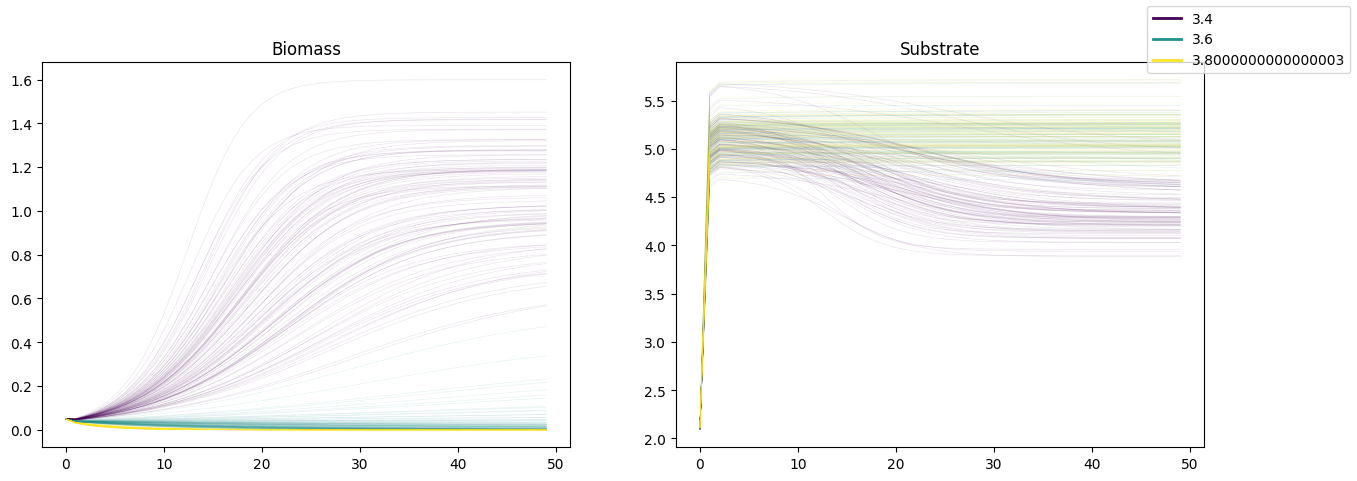

In [39]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D


def simulate_timecourse(idata, D, chain, draw):
    tc_params = {
        'log_D': jnp.log(D),        
        'log_S_F': idata.posterior["log_S_F"].sel(chain=chain, draw=draw).item(),
        'log_conc_init': np.log(jnp.array([X_0, S_0])),
        'log_gamma': idata.posterior["log_gamma"].sel(chain=chain, draw=draw).item(),
        'log_ks': idata.posterior["log_ks"].sel(chain=chain, draw=draw).item(),
        'log_mu_max': idata.posterior["log_mu_max"].sel(chain=chain, draw=draw).item(),
    }
    return solve_reactor(tc_params, timepoints).ys

cmap = plt.get_cmap('viridis')
chain_arr = jnp.array([0, 1])
draw_arr = jnp.arange(50)
D_arr = jnp.linspace(3.4, 3.8, 3) 
norm = Normalize(vmin=0, vmax=len(D_arr) - 1)
scalar_map = ScalarMappable(norm=norm, cmap=cmap)

f, axes = plt.subplots(1, 2, figsize=[15, 5])
labels = []
lines = []
for i, D in enumerate(D_arr):
    color = scalar_map.to_rgba(i)
    labels.append(str(round(D, 2)))
    lines.append(Line2D([0], [0], color=color, lw=2))
    for chain in chain_arr:
        for draw in draw_arr:
            ys = simulate_timecourse(idata, D, chain, draw)
            axes[0].plot(ys[:, 0], color=color, linewidth=0.5, alpha=0.1)
            axes[1].plot(ys[:, 1], color=color, linewidth=0.5, alpha=0.1)
axes[0].set(title="Biomass")
axes[1].set(title="Substrate")
f.legend(lines, labels)